2019-06-25
36780 - 31341 = 5439 rub., 17%


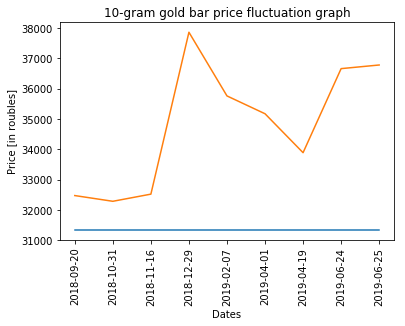

In [14]:
# Get the current price of a 10-gram gold bar from the bank site and compare it to the purchase price
import csv
from datetime import datetime
import json
import matplotlib.pyplot as plt
import pandas as pd
import requests
import xlrd

# Secure from the non-operating site
def get_url(url):
    try:
        result = requests.get(url)
        result.raise_for_status()
        return result.content
    except(requests.RequestException, ValueError):
        print("сетевая ошибка")
        return False


# Open up the necessary page of the bank's site
contents = get_url("https://www.sberbank.ru/proxy/services/dict-services/document/list?groupCode=279&regionCode=77&month=5&year=2019")

# Download the latest published xls file with prices
if contents:
    part_of_the_link = json.loads(contents)[-1]
    part_of_the_link = part_of_the_link['fileUrl']
    whole_link = "http://sberbank.ru" + part_of_the_link
    xls_file = requests.get(whole_link, allow_redirects=True)

    # Get the date from the link for further analysis
    date_from_link = whole_link.split("/dm")[1][:6]
    date_from_link = datetime.strptime(date_from_link, '%d%m%y')
    date_from_link = datetime.date(date_from_link)
    print(date_from_link)
    
   # Retrieve the current gold bar value from the necessary cell of the file's first sheet
    open('gold.xls', 'wb').write(xls_file.content)
    book = xlrd.open_workbook("gold.xls", encoding_override="cp1252")
    sheet = book.sheet_by_index(0)
    new_price = int(sheet.cell_value(11, 3))

    # Substract the current price from the purchase price and express it as a sum of money and percent
    old_price = 31341
    percentage = int(((new_price - old_price)*100)/old_price)
    print(f"{new_price} - 31341 = {int(new_price - old_price)} rub., {percentage}%")

    # Check if current date and price are already kept the csv file (if script is run several times a day)
    date_list = []
    with open("gold.csv", "r", encoding = "cp1251") as file:
        reader = csv.DictReader(file, delimiter = ";")
        for line in reader:
            date_list.append(line['date'])
    # Write down current date and price into a csv file if they are new to the file
    if date_list[-1] != str(date_from_link):
        data = {'date': date_from_link, 'old_price': old_price, 'new_price': new_price, 'percentage': percentage}
        with open("gold.csv", "a", encoding = "cp1251", newline = "") as f:
            fieldnames = ["date", "old_price", "new_price", "percentage"]
            writer = csv.DictWriter(f, fieldnames, delimiter = ";")
            writer.writerow(data)
            
    # Show the graphs with the current price value and the old price value (in Jupyter) using data from csv file
    dataframe = pd.read_csv('gold.csv', sep=';')
    dataframe.drop_duplicates('date')
    plt.plot(dataframe['date'], dataframe['old_price'])
    plt.plot(dataframe['date'], dataframe['new_price'])

    # Gives names to the plot and its axis
    plt.title('10-gram gold bar price fluctuation graph')
    plt.xlabel('Dates')
    plt.ylabel('Price [in roubles]')
    
    # Make position of dates' inscriptions vertical (otherwise they get unreadable)
    plt.xticks(dataframe['date'], rotation='vertical')
    plt.show()